# **Tweet Sentiment Extraction **

Importing the Necessary libraries

In [ ]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator ##is a data visualization technique used
#for representing text data in which the size of each word indicates its frequency


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm ##new progress bars repeatedly
import os 
import nltk ##building Python programs to work with human language data
import spacy #for training the NER model tokenize words
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [ ]:
train=pd.read_csv('gdrive/My Drive/Sentiment Analysis/train.csv')
test=pd.read_csv('gdrive/My Drive/Sentiment Analysis/test.csv')
ss=pd.read_csv('gdrive/My Drive/Sentiment Analysis/sample_submission.csv')

In [ ]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


So We have 27486 tweets in the train set and 3535 tweets in the test set



In [ ]:
train.info()  #Get the summary of this dataframe


**We have one null Value in the train , as the test field for value is NAN we will just remove it**

In [ ]:
train.dropna(inplace=True)

In [ ]:
test.info()    #We have no null values in this data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [ ]:
train.head()  #print the first five rows 

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


**Note that selected_text is a subset of text**

In [ ]:
train.describe()   #Generate the descriptive stats

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,89cd7f2945,Hi Sharon Missed you on our x factor last yea...,good,neutral
freq,1,1,199,11117


We now look at the distribution of tweets in this train data

In [ ]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


We now plot a bar graph to visualize the distribution of the sentiments

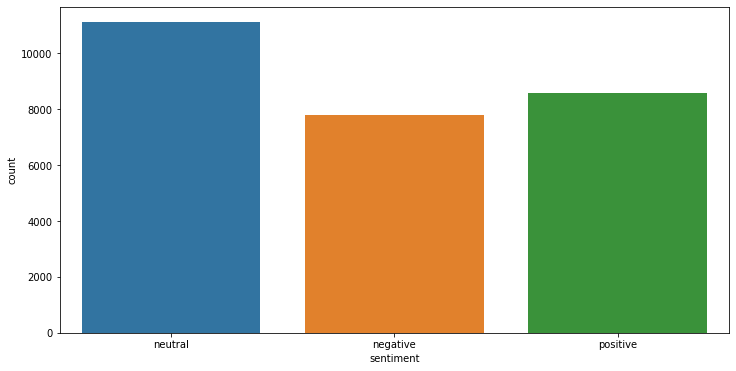

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

A funnel-chart gives better visualization

**Facts we currently know about the data**

We Know that selected_text is a subset of text

We know that selected_text contains only one segment of text,i.e,It does not 
jump between two sentences.For Eg:- If text is 'Spent the entire morning in a meeting w/ a vendor, and my boss was not happy w/ them. Lots of fun. I had other plans for my morning' The selected text can be 'my boss was not happy w/ them. Lots of fun' or 'Lots of fun' but cannot be 'Morning,vendor and my boss,

We know that neutral tweets have a jaccard similarity of 97 percent between text and selected_text

Also as discussed here https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/138272 ,there are rows where selected_text starts from between the words and thus selected_texts dont always make sense and since we do not know whether the output of test set contain these descrepancies or not ,we are not sure that preprocessing and removing punctuations would be a good idea or not


**Performing EDA** # for seeing what the data can tell us beyond the formal modeling or hypothesis testing task.


## **Generating Meta-Features**

More useful features to generate would be :-

Difference In Number Of words of Selected_text and Text
Jaccard Similarity Scores between text and Selected_text


In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [ ]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [ ]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [ ]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


Looking at the distribution of meta features,

In [ ]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

The number of word distribution is skewed to the right since we have very less tweets with words greater than 25

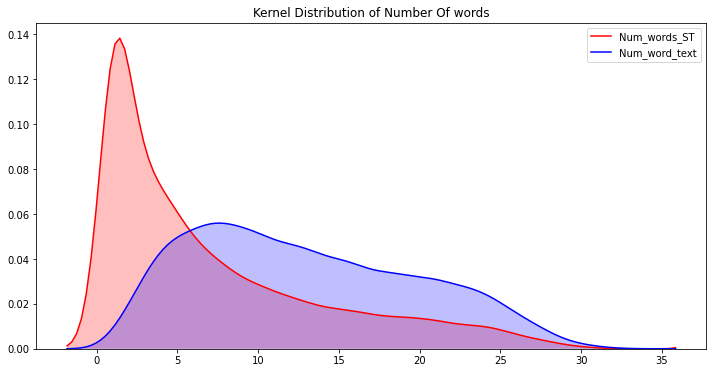

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="b")

**Now It will be more interesting to see the differnce in number of words and jaccard_scores across different Sentiments**



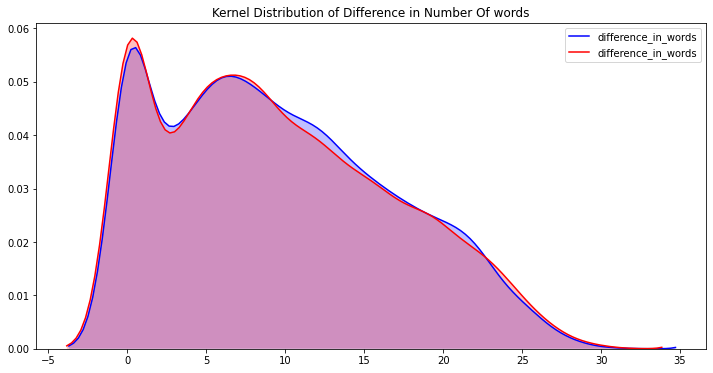

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r")

No major difference between number of words in negative and positive sentiments

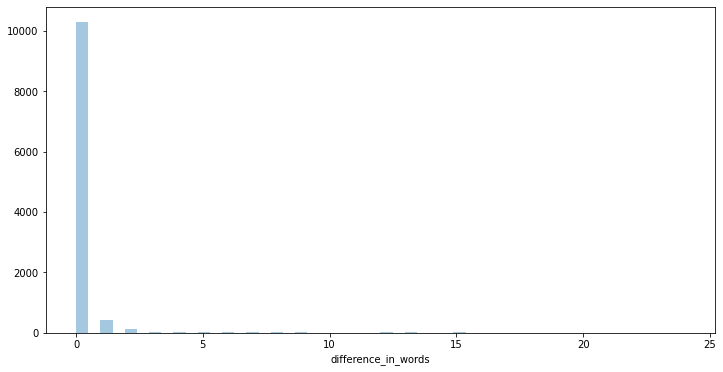

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['difference_in_words'],kde=False)

We did not plot a KDE plot for neutral tweets since Most of the values for difference in number of words were zero. We can see it clearly now ,if we had used the feature in the starting we would have known that text and selected text are mostly the same for neutral tweets,thus its always important to keep the end goal in mind while performing EDA

**KDE** Generate Kernel Density Estimate plot using Gaussian kernels. In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function (PDF) of a random variable.

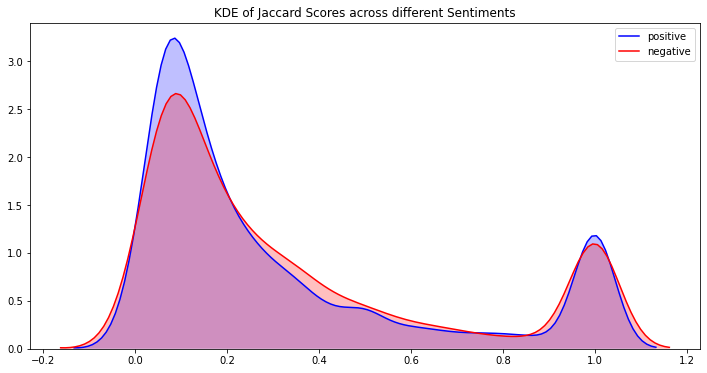

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

We were not able to plot kde of jaccard_scores of neutral tweets for the same reason,thus I will plot a distribution plot

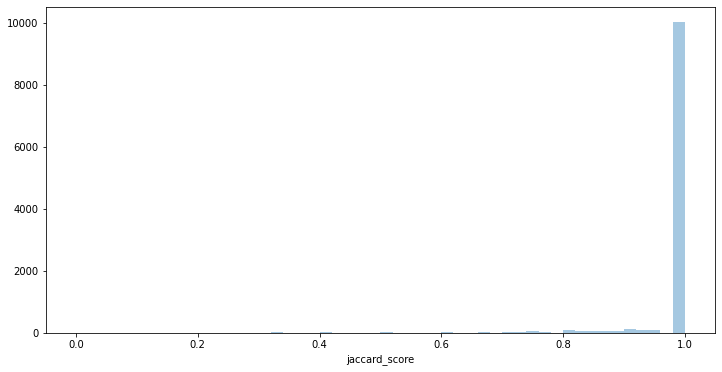

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'],kde=False)

**We can see some interesting trends here:**

Positive and negative tweets have high kurtosis and thus values are concentrated in two regions narrow and high density
Neutral tweets have a low kurtosis value and their is bump in density near values of 1


Kurtosis is the measure of how peaked a distribution is and how much spread it is around that peak
**Skewness** measures how much a curve deviates from a normal distribution


**Conclusion Of EDA**

We can see from the jaccard score plot that there is peak for negative and positive plot around score of 1 .That means there is a cluster of tweets where there is a high similarity between text and selected texts ,if we can find those clusters then we can predict text for selected texts for those tweets irrespective of segment

Let's see if we can find those clusters,one interesting idea would be to check tweets which have number of words lesss than 3 in text, because there the text might be completely used as text

In [ ]:
k = train[train['Num_word_text']<=2]

In [ ]:
k.groupby('sentiment').mean()['jaccard_score']

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard_score, dtype: float64

We can see that there is similarity between text and selected text .Let's have closer look

In [ ]:
k[k['sentiment']=='positive']

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
68,fa2654e730,Chilliin,Chilliin,positive,1.0,1,1,0
80,bbbc46889b,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,positive,1.0,2,2,0
170,f3d95b57b1,good morning,good morning,positive,1.0,2,2,0
278,89d5b3f0b5,Thanks,Thanks,positive,1.0,1,1,0
429,a78ef3e0d0,Goodmorning,Goodmorning,positive,1.0,1,1,0
...,...,...,...,...,...,...,...,...
26689,e80c242d6a,Goodnight;,Goodnight;,positive,1.0,1,1,0
26725,aad244f37d,*hug*,*hug*,positive,1.0,1,1,0
26842,a46571fe12,congrats!,congrats!,positive,1.0,1,1,0
26959,49a942e9b1,Happy birthday.,Happy birthday.,positive,1.0,2,2,0


Thus its clear that most of the times , text is used as selected text.We can improve this by preprocessing the text which have word length less than 3.We will remember this information and use it in model building

Before We Dive into extracting information out of words in text and selected text,let's first clean the data

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [ ]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11


**Most Common words in our Target-Selected Text**

In [ ]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,i,7200
1,to,5305
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


Lets visualize this

In [ ]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

We have common words as to,the...which are stopwords,when we cleaned the data , we did not remove them.
***stopwords***
*In natural language processing, useless words (data), are referred to as stop words. ... Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.*


In [ ]:
import nltk
nltk.download()
#showing info http://nltk.github.com/nltk_data/

In [ ]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))

In [ ]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


The stop words are all gone ,We can dow do a tree map

In [ ]:
pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.8.1)


In [ ]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

**Most Common words in Text**  : We can look at this too

In [ ]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [ ]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


In [ ]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

From this figure of texts and the previous for selected text,we can see that most common words are almost the same which is unsuprising since selected text is removed from text.

# **Now lets look for common words in different sentiments**

In [ ]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [ ]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,826
1,happy,730
2,love,697
3,day,456
4,thanks,439
5,great,364
6,fun,287
7,nice,267
8,mothers,259
9,hope,245


In [ ]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162
10,sucks,159


In [ ]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

In [ ]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,get,612
2,go,569
3,day,492
4,dont,482
5,going,472
6,work,467
7,like,445
8,got,441
9,today,427
10,lol,427


In [ ]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

We can see words like get,go,dont,got,u,cant,lol,like are common in all three segments . That's interesting because words like dont and cant are more of negative nature and words like lol are more of positive nature.Does this mean our data is incorrectly labelled , we will have more insights on this after N-gram analysis
It will be interesting to see the word unique to different sentiments

**Let's Look at Unique Words in each Segment**
# We will look at unique words in each segment in the Following Order:

1.   Positive
2.   Negative
3.   Neutral


In [ ]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

In [ ]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

1. ### Positive Tweets

In [ ]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,shared,7
4,presents,7
5,greetings,7
6,blessings,6
7,mothersday,6
8,mcr,6
9,coolest,6


In [ ]:
fig = px.treemap(Unique_Positive, path=['words'], values='count',title='Tree Of Unique Positive Words')
fig.show()

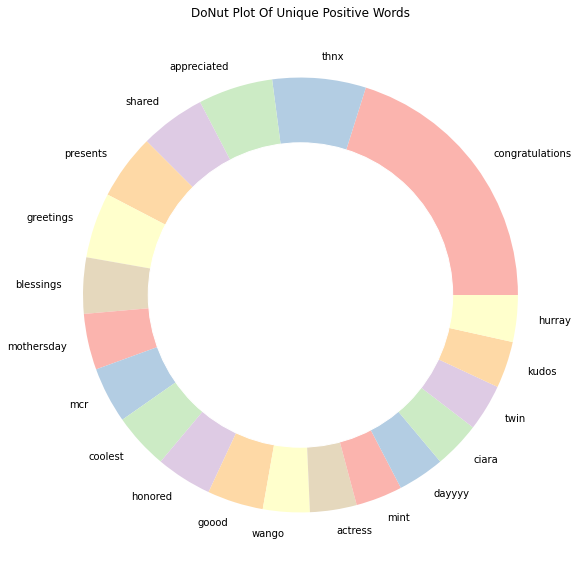

In [ ]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

In [ ]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,ache,12
1,suffering,9
2,allergic,7
3,cramps,7
4,saddest,7
5,pissing,7
6,sob,6
7,dealing,6
8,devastated,6
9,noes,6


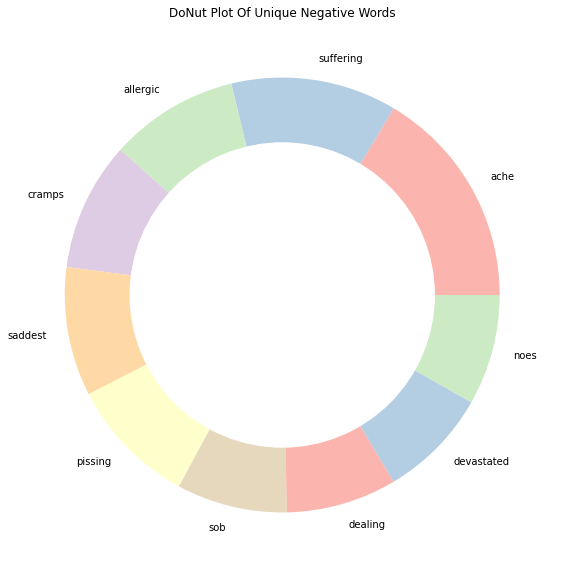

In [ ]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Negative Words')
plt.show()

In [ ]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,settings,9
1,explain,7
2,mite,6
3,hiya,6
4,reader,5
5,pr,5
6,sorta,5
7,fathers,5
8,enterprise,5
9,guessed,5


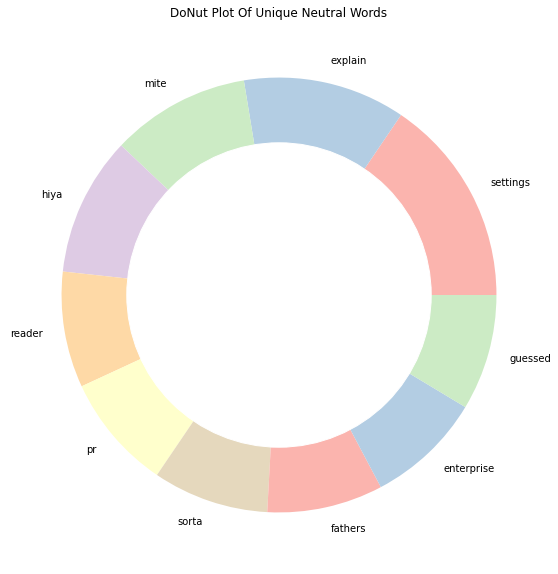

In [ ]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Neutral Words')
plt.show()

# **By Looking at the Unique Words of each sentiment,we now have much more clarity about the data,these unique words are very strong determiners of Sentiment of tweets**



```
`# This is formatted as code`
```

## WordClouds

We will be building wordclouds in the following order:

* WordCloud of Neutral Tweets
* WordCloud of Positive Tweets
* WordCloud of Negative Tweets

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path1='gdrive/My Drive/Sentiment Analysis'
os.listdir(path1)

Mounted at /content/gdrive


['sample_submission.csv',
 'test.csv',
 'train.csv',
 'sentiment.jpg',
 'star.png',
 'upvote.png',
 'user.png',
 'loc.png',
 'comment.png']

In [ ]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d ='gdrive/My Drive/Sentiment Analysis'



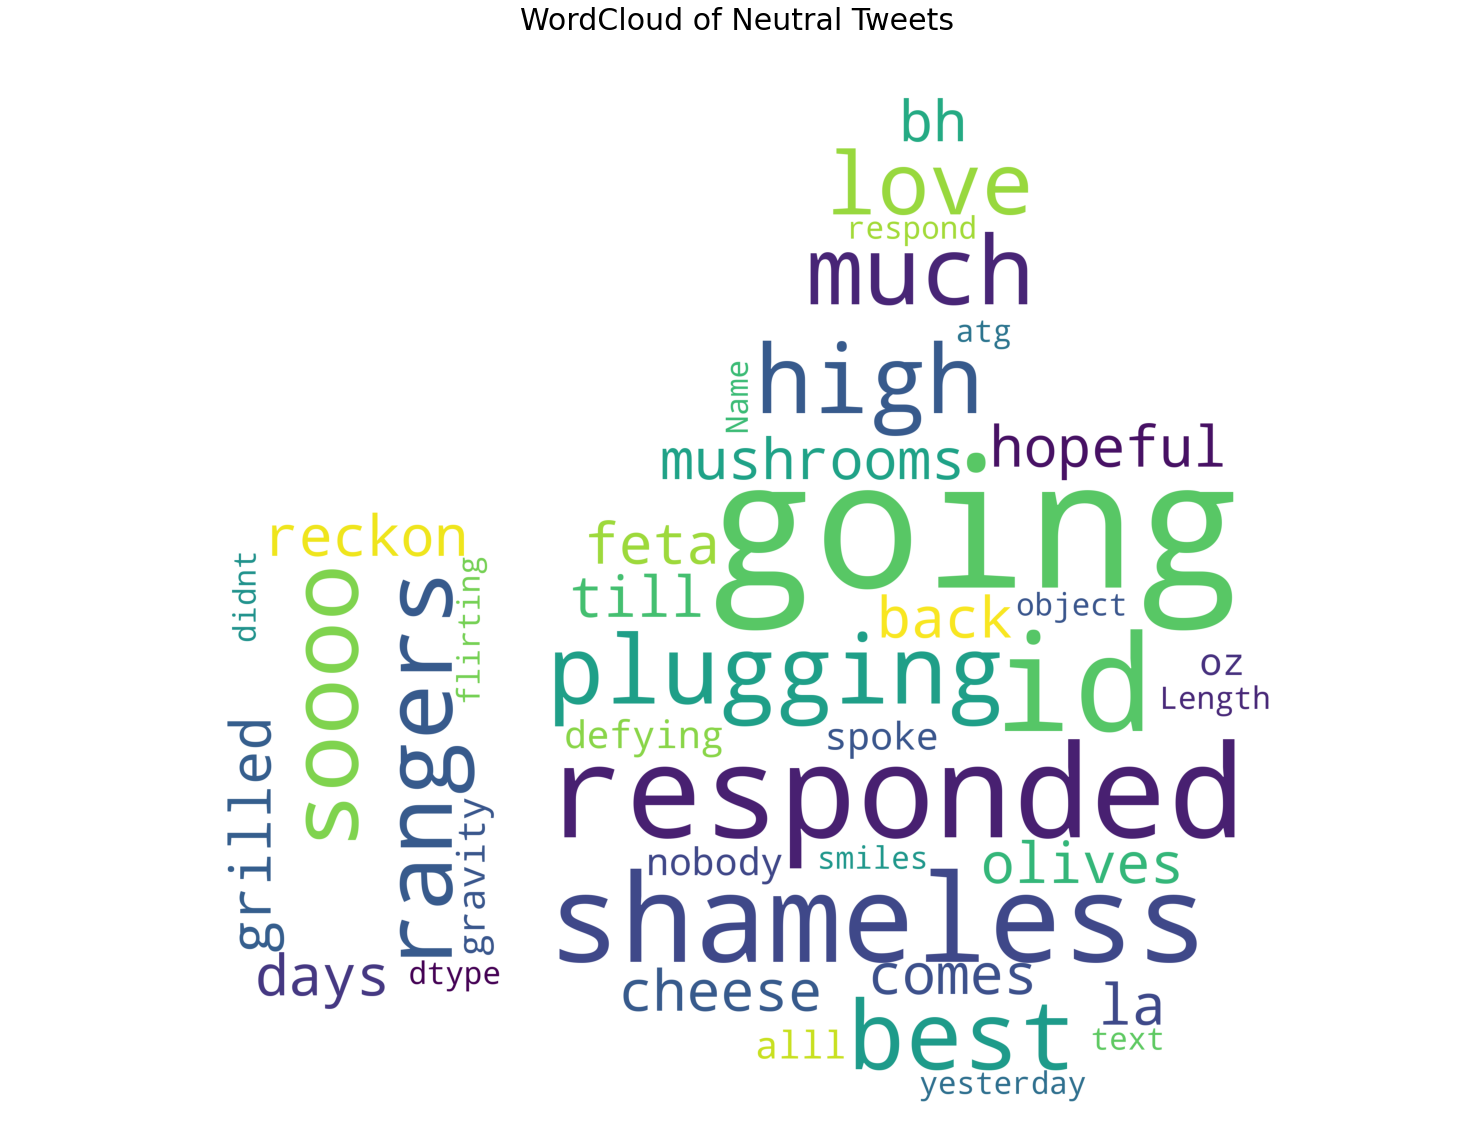

In [ ]:

pos_mask = np.array(Image.open(d+'/upvote.png'))
plot_wordcloud(Neutral_sent.text,mask=pos_mask,color='white',max_font_size=500,title_size=30,title="WordCloud of Neutral Tweets")

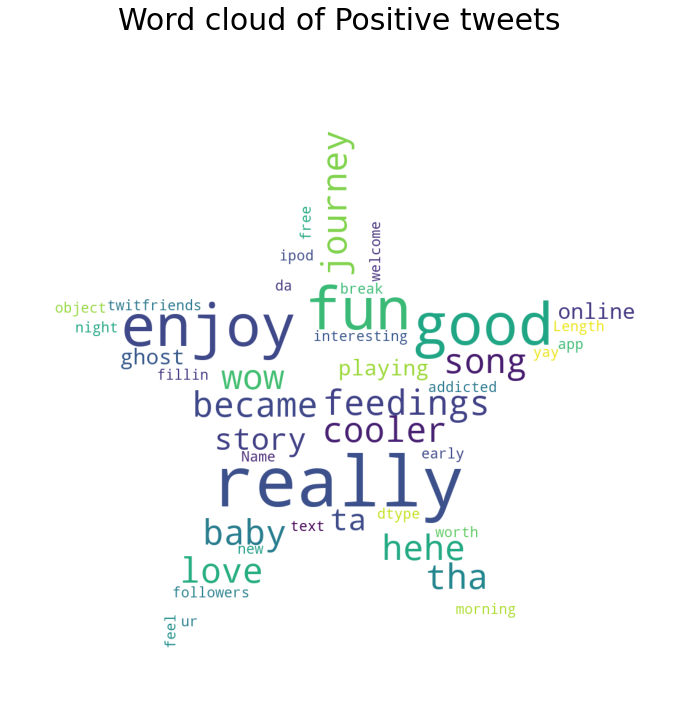

In [ ]:
pos_mask = np.array(Image.open(d+'/star.png'))
plot_wordcloud(Positive_sent.text,mask=pos_mask,title="Word cloud of Positive tweets",max_font_size=500,title_size=30,figure_size=(20.0,10.0))

We added more words like im , u (that we say were there in the most common words,disturbing our analysis) as stopwords

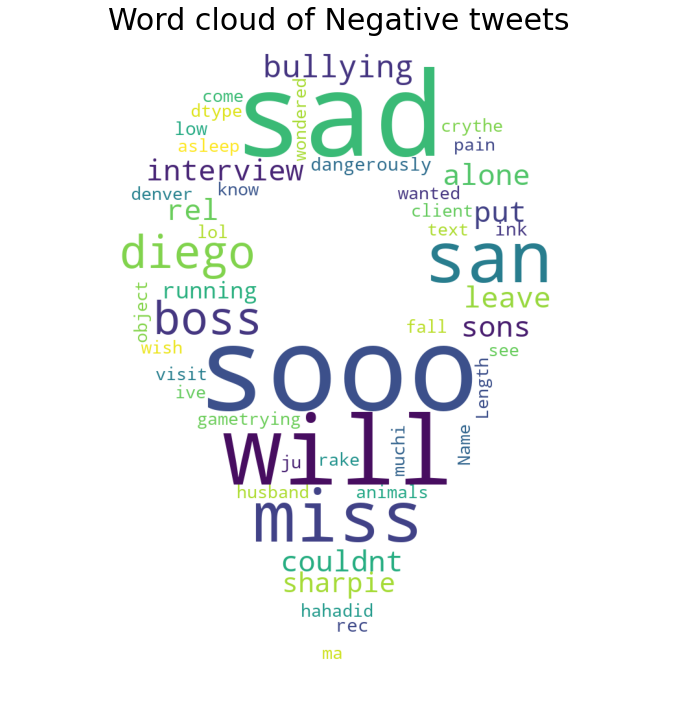

In [ ]:
pos_mask = np.array(Image.open(d+'/loc.png'))
plot_wordcloud(Negative_sent.text,mask=pos_mask,title="Word cloud of Negative tweets",max_font_size=500,title_size=30,figure_size=(20.0,10.0))